In [1]:
import numpy as np
import pandas as pd

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


In [4]:
X_train.head(20)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.748570,2.103000,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.339950,1.506400,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.264290,1.592200,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.426840,1.099300,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.509690,1.468900,-10.4410
5,0_5,0,5,-0.75853,-0.63439,-0.10483,-0.10580,0.059664,0.013043,-0.013231,-0.447450,0.992810,-10.4020
6,0_6,0,6,-0.75853,-0.63441,-0.10481,-0.10569,0.082140,0.044356,-0.002696,-0.141630,0.734970,-9.4296
7,0_7,0,7,-0.75852,-0.63444,-0.10480,-0.10561,0.056218,0.038162,-0.022931,-0.121600,0.075417,-8.6088
8,0_8,0,8,-0.75851,-0.63445,-0.10485,-0.10559,-0.012846,0.039004,-0.007831,1.600000,0.816110,-7.6426
9,0_9,0,9,-0.75851,-0.63443,-0.10489,-0.10567,-0.090082,0.027299,-0.009970,0.474960,0.909600,-8.8120


In [8]:
from scipy.spatial.transform import Rotation as R

In [10]:
series0 = X_train.loc[0:127,['orientation_W','orientation_X','orientation_Y','orientation_Z' ]]

In [11]:
rots = R.from_quat(series0)

In [41]:
a = rots.as_euler('zyx')

In [42]:
a

array([[-3.11261021,  0.29794277, -1.75298305],
       [-3.11258625,  0.29801276, -1.7530032 ],
       [-3.11266302,  0.29800367, -1.75297602],
       [-3.11270696,  0.29805013, -1.75294162],
       [-3.11272031,  0.29803919, -1.75295497],
       [-3.11282525,  0.29764536, -1.75288433],
       [-3.11297916,  0.2974727 , -1.7528277 ],
       [-3.11310281,  0.29735391, -1.75274792],
       [-3.113205  ,  0.29740556, -1.75270487],
       [-3.11312529,  0.29757081, -1.75275024],
       [-3.11310881,  0.29780096, -1.75271714],
       [-3.1131714 ,  0.29780694, -1.75267934],
       [-3.1131784 ,  0.2977039 , -1.75260176],
       [-3.11324176,  0.29788383, -1.75264141],
       [-3.11321629,  0.29812571, -1.7525658 ],
       [-3.11315617,  0.29852282, -1.75252869],
       [-3.1131475 ,  0.29882389, -1.75249544],
       [-3.11306339,  0.29842954, -1.7524403 ],
       [-3.11302386,  0.29828174, -1.75241306],
       [-3.1130324 ,  0.29830946, -1.75233968],
       [-3.11295499,  0.29856228, -1.752

In [43]:
b = np.roll(a,-1,axis=0)

In [44]:
a-b

array([[-2.39560167e-05, -6.99928867e-05,  2.01498430e-05],
       [ 7.67669026e-05,  9.09056238e-06, -2.71766507e-05],
       [ 4.39448532e-05, -4.64604096e-05, -3.44029720e-05],
       [ 1.33493176e-05,  1.09408090e-05,  1.33493176e-05],
       [ 1.04934151e-04,  3.93831159e-04, -7.06348657e-05],
       [ 1.53912667e-04,  1.72656705e-04, -5.66358476e-05],
       [ 1.23653622e-04,  1.18792093e-04, -7.97805986e-05],
       [ 1.02190343e-04, -5.16492076e-05, -4.30495345e-05],
       [-7.97119035e-05, -1.65248893e-04,  4.53765721e-05],
       [-1.64825548e-05, -2.30158020e-04, -3.31064861e-05],
       [ 6.25923168e-05, -5.97675310e-06, -3.77954531e-05],
       [ 6.99883816e-06,  1.03036572e-04, -7.75784578e-05],
       [ 6.33630410e-05, -1.79929248e-04,  3.96447216e-05],
       [-2.54718610e-05, -2.41875338e-04, -7.56058446e-05],
       [-6.01222446e-05, -3.97107303e-04, -3.71093157e-05],
       [-8.66544772e-06, -3.01078453e-04, -3.32550045e-05],
       [-8.41121612e-05,  3.94356916e-04

In [45]:
d = pd.DataFrame(a)
d

,0,1,2
0,-3.112610,0.297943,-1.752983
1,-3.112586,0.298013,-1.753003
2,-3.112663,0.298004,-1.752976
3,-3.112707,0.298050,-1.752942
4,-3.112720,0.298039,-1.752955
5,-3.112825,0.297645,-1.752884
6,-3.112979,0.297473,-1.752828
7,-3.113103,0.297354,-1.752748
8,-3.113205,0.297406,-1.752705
9,-3.113125,0.297571,-1.752750


In [32]:
import seaborn as sns

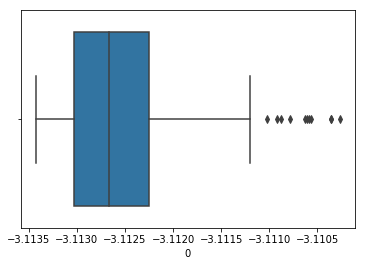

In [46]:
sns.boxplot(d[0])

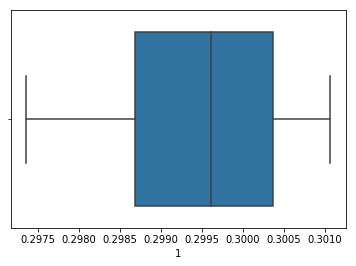

In [47]:
sns.boxplot(d[1])

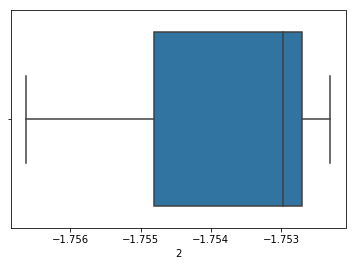

In [48]:
sns.boxplot(d[2])

In [52]:
vel = X_train.loc[0:127,['angular_velocity_X','angular_velocity_Y','angular_velocity_Z']]

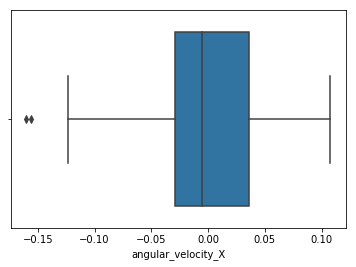

In [53]:
sns.boxplot(vel['angular_velocity_X'])

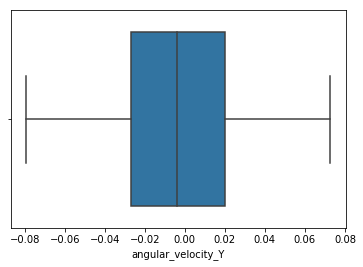

In [54]:
sns.boxplot(vel['angular_velocity_Y'])

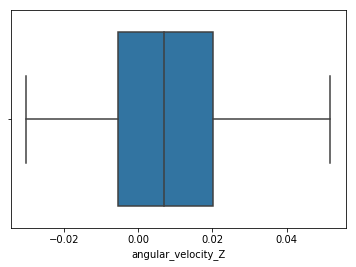

In [55]:
sns.boxplot(vel['angular_velocity_Z'])